# Pokemon Classification

In [2]:
from google.colab import drive
additional_path='/MyDrive'
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf

In [8]:
drive_path='/content/drive/My Drive/pokemon-classification/' # change the path name as your favorite.

## 0. Data Preparation

In [5]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

# convert_img: This function loads an image, resizes it, and normalizes its pixels. This ensures that the image is prepared in a way that matches the preprocessing required for neural network inputs.
def convert_img(image_path, save_path=None, show=False):
    img = load_img(image_path, target_size=(224, 224))  # Load and resize the image
    img_array = img_to_array(img)  # Convert the image to an array
    img_normalized = img_array / 255.  # Normalize the image

    if save_path:  # Check if a save path is provided
        save_img(save_path, img_normalized)  # Save the normalized image

    if show:  # Check if the image is to be displayed
        plt.imshow(img_normalized)
        plt.title('Processed Image')
        plt.axis('off')
        plt.show()

    return img_normalized


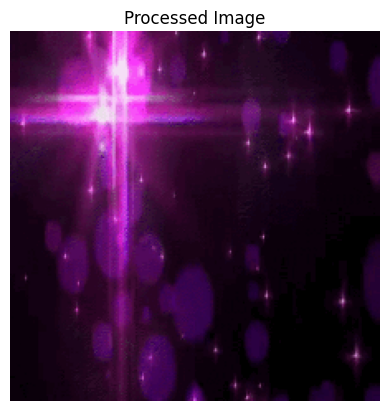

In [9]:
out=convert_img(drive_path+'example.gif', save_path='example.jpg', show=True)

In [ ]:
type(out)

numpy.ndarray

In [14]:
import os
from concurrent.futures import ThreadPoolExecutor

def process_image(file_info):
    root, file = file_info
    if file.endswith((".jpg", ".png")):  # Check for .jpg or .png files
        path = os.path.join(root, file)  # Full path to the file
        label = os.path.basename(root)  # Directory name as label
        processed_image = convert_img(path)  # Process image
        return (processed_image, label)
    return None

def label_src(src_directory):
    data = []
    # Prepare list of all files
    files_to_process = []
    for root, dirs, files in os.walk(src_directory):
        for file in files:
            files_to_process.append((root, file))

    # Use ThreadPoolExecutor to process images in parallel
    with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
        results = executor.map(process_image, files_to_process)

    # Filter out None results and append others to data
    for result in results:
        if result is not None:
            data.append(result)

    return data

In [15]:
raw_data=label_src(drive_path+'src')

In [16]:
print(type(raw_data))
print(type(raw_data[0]))
print(type(raw_data[0][0]))
print(len(raw_data))

<class 'list'>
<class 'tuple'>
<class 'numpy.ndarray'>
3002


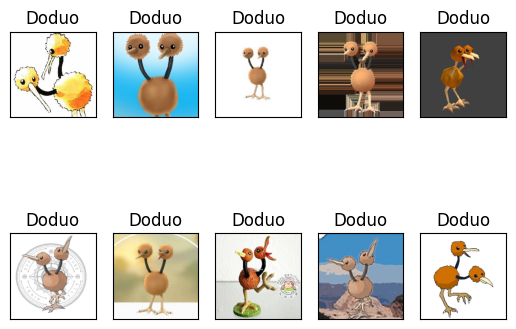

In [17]:
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(raw_data[i][0])
    plt.xticks([])
    plt.yticks([])
    plt.title(raw_data[i][1])
plt.show()


## 1. Data Preprocessing

In [18]:
labels = []
for _, i in raw_data:
    if i not in labels: labels.append(i)
# for _, i in raw_data:
#     if i in labels: labels[i]+=1
#     else: labels[i]=1
#labels=sorted(list(labels.keys()))
labels.sort()
print(len(labels))
print(labels[:5])

inv_label={}
for i, label in enumerate(labels):
    inv_label[label]=i
# print(inv_label)

307
['Abra', 'Absol', 'Accelgor', 'Aegislash', 'Aipom']


In [19]:
trainval_set, test = train_test_split(raw_data, test_size=0.2, random_state=42)
train, valid = train_test_split(trainval_set, test_size=0.2, random_state=42)

x_train, y_train = np.array(list(map(lambda x: x[0], train))), np.array(list(map(lambda x: inv_label[x[1]], train)))
#print(x_train[0].shape, len(x_train)) # (227, 227, 3) 5940
x_test, y_test = np.array(list(map(lambda x: x[0], test))), np.array(list(map(lambda x: inv_label[x[1]], test)))
x_valid, y_valid = np.array(list(map(lambda x: x[0], valid))), np.array(list(map(lambda x: inv_label[x[1]], valid)))

In [20]:
print(f'x_train.shape: {x_train.shape},\ty_train.shape: {y_train.shape}')
print(f'x_test.shape: {x_test.shape},\ty_test.shape: {y_test.shape}')
print(f'x_valid.shape: {x_valid.shape},\ty_valid.shape: {y_valid.shape}')

x_train.shape: (1920, 224, 224, 3),	y_train.shape: (1920,)
x_test.shape: (601, 224, 224, 3),	y_test.shape: (601,)
x_valid.shape: (481, 224, 224, 3),	y_valid.shape: (481,)


## 2-1. Model1: Plain Convolution 2D Layer

In [27]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')  # number of classes
])

In [28]:
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [29]:
hist = cnn_model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
60/60 [==============================] - 13s 83ms/step - loss: 5.4492 - accuracy: 0.0224 - val_loss: 4.6630 - val_accuracy: 0.0603
Epoch 2/20
60/60 [==============================] - 5s 76ms/step - loss: 4.3792 - accuracy: 0.0875 - val_loss: 4.1204 - val_accuracy: 0.1809
Epoch 3/20
60/60 [==============================] - 4s 65ms/step - loss: 3.5438 - accuracy: 0.2510 - val_loss: 3.5003 - val_accuracy: 0.3514
Epoch 4/20
60/60 [==============================] - 4s 65ms/step - loss: 2.5308 - accuracy: 0.4536 - val_loss: 3.2793 - val_accuracy: 0.3742
Epoch 5/20
60/60 [==============================] - 4s 69ms/step - loss: 1.6103 - accuracy: 0.6385 - val_loss: 3.3180 - val_accuracy: 0.4116
Epoch 6/20
60/60 [==============================] - 4s 68ms/step - loss: 1.0017 - accuracy: 0.7729 - val_loss: 3.6762 - val_accuracy: 0.3929
Epoch 7/20
60/60 [==============================] - 4s 66ms/step - loss: 0.5558 - accuracy: 0.8583 - val_loss: 3.8725 - val_accuracy: 0.4324
Epoch 8/20
6

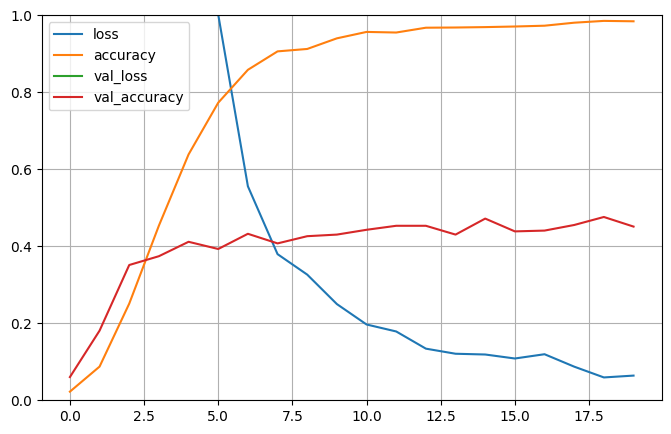

In [34]:
# Training Visualization

def visualize_hist(hist):
  pd.DataFrame(hist.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)

  plt.show()

visualize_hist(hist)

In [31]:
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)


19/19 [==============================] - 1s 49ms/step - loss: 5.1297 - accuracy: 0.4276
Test accuracy: 0.42762061953544617


In [32]:
cnn_model.save('pokemon_classifier_cnn_model.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
from keras.models import load_model
model = load_model('pokemon_classifier_cnn_model.h5')


In [ ]:
# Grading - test data로 진행한다고 한다!! (fixed)
# "Practicing the final project...!"

import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2-2. Model2: Fine-tune from VGG-16

In [36]:
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam

# Load VGG16 pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Create the model
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(labels), activation='softmax')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 2s 0us/step


In [37]:
# Example of training; adjust parameters as necessary
hist=model.fit(x_train, y_train, epochs=20, validation_data=(x_valid, y_valid))

Epoch 1/20
60/60 [==============================] - 26s 244ms/step - loss: 4.7630 - accuracy: 0.1203 - val_loss: 3.2879 - val_accuracy: 0.4096
Epoch 2/20
60/60 [==============================] - 13s 209ms/step - loss: 2.4539 - accuracy: 0.5156 - val_loss: 2.0521 - val_accuracy: 0.6570
Epoch 3/20
60/60 [==============================] - 12s 197ms/step - loss: 1.2411 - accuracy: 0.7437 - val_loss: 1.7979 - val_accuracy: 0.6902
Epoch 4/20
60/60 [==============================] - 12s 206ms/step - loss: 0.6430 - accuracy: 0.8557 - val_loss: 1.7295 - val_accuracy: 0.7214
Epoch 5/20
60/60 [==============================] - 12s 198ms/step - loss: 0.2529 - accuracy: 0.9391 - val_loss: 1.7116 - val_accuracy: 0.7110
Epoch 6/20
60/60 [==============================] - 12s 207ms/step - loss: 0.1217 - accuracy: 0.9698 - val_loss: 1.7002 - val_accuracy: 0.7297
Epoch 7/20
60/60 [==============================] - 12s 201ms/step - loss: 0.0761 - accuracy: 0.9818 - val_loss: 1.8334 - val_accuracy: 0.7152

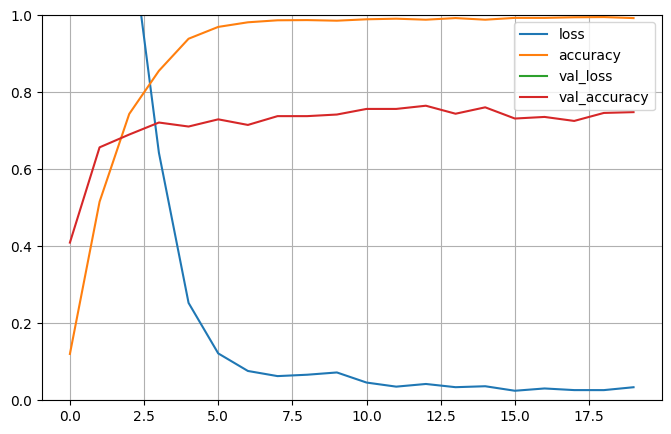

19/19 [==============================] - 0s 24ms/step - loss: 5.1297 - accuracy: 0.4276
Test accuracy: 0.42762061953544617


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
visualize_hist(hist)
test_loss, test_acc = cnn_model.evaluate(x_test, y_test)
print("Test accuracy:", test_acc)
model.save('pokemon_classifier_vgg16_1_model.h5')

## 3. Classification

In [40]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np

def preprocess_image(image_path, target_size):
    # Load the image
    img = load_img(image_path, target_size=target_size)
    # Convert the image to an array
    img_array = img_to_array(img)
    # Expand dimensions to match the batch size
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image
    img_array /= 255.0
    return img_array

# Example usage
image_path = 'example.gif'
processed_image = preprocess_image(image_path, target_size=(224, 224))


In [48]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('pokemon_classifier_vgg16_1_model.h5')
predictions = model.predict(processed_image)
print(predictions.shape)
# print(predictions)  # Outputs probability for each class
pred_idx = np.argmax(predictions, axis=1)[0]

predicted_label = labels[pred_idx]
prob = predictions[0,pred_idx]
print(predicted_label, prob)

1/1 [==============================] - 0s 137ms/step
(1, 307)
Diglett 0.5912472
